# CNN

In this notebook, we will go through basics of CNN using MNIST dataset.

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Hey yo, but what is CNN?

Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/cnn/mnist/2018/10/17/Force-of-Convolutional-Neural-Networks/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/CNN/mnist_cnn_pytorch.ipynb)

# Install dependencies

In [0]:
!pip install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.0.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)


# PyTorch

In [0]:
# load all the required libraries
import copy
import time
import numpy as np                                    # package for computing
from sklearn.model_selection import train_test_split  # split dataset
import torch                                          # import keras with tensorflow as backend
from torchvision import datasets                      # import mnist dataset from keras 
from torchvision import transforms            # sequential and functional api keras 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt             # matplotlib library for plotting

# display plots inline (in notebook itself)
%matplotlib inline              

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Training on %s ...'%format(device))

Training on cuda:0 ...


In [0]:
# load mnist data

batch_size = 256
num_workers = 0
val_size = 0.2

transform = transforms.Compose([transforms.ToTensor()])

# choose the training and test datasets
train_data = datasets.MNIST('data', train=True,
                              download=True, transform=transform)
test_data = datasets.MNIST('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_test = len(test_data)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_test))
test_idx, val_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(val_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

print('Training samples:', len(train_loader.dataset))
print ('Validation samples:', len(val_loader.dataset))
print('Test samples:', len(test_loader.dataset))

# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 
                    'val': val_loader}


Training samples: 60000
Validation samples: 10000
Test samples: 10000


# 

From the previous post, we learned how to split dev and test data.
Here, we keep the dimensions of the data same.




## Visualization of data

Enough talk, show me the data!

In [0]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.squeeze(np.transpose(img, (1, 2, 0))), cmap='gray')  # convert from Tensor image

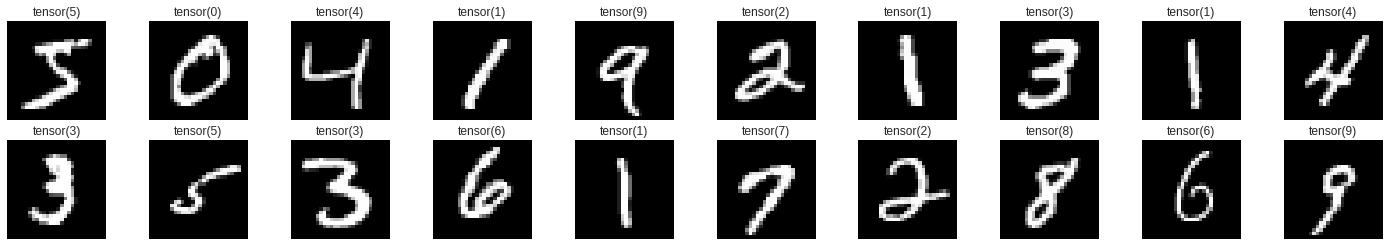

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
#display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # print out the correct label for each image
    ax.set_title(str(labels[idx]))

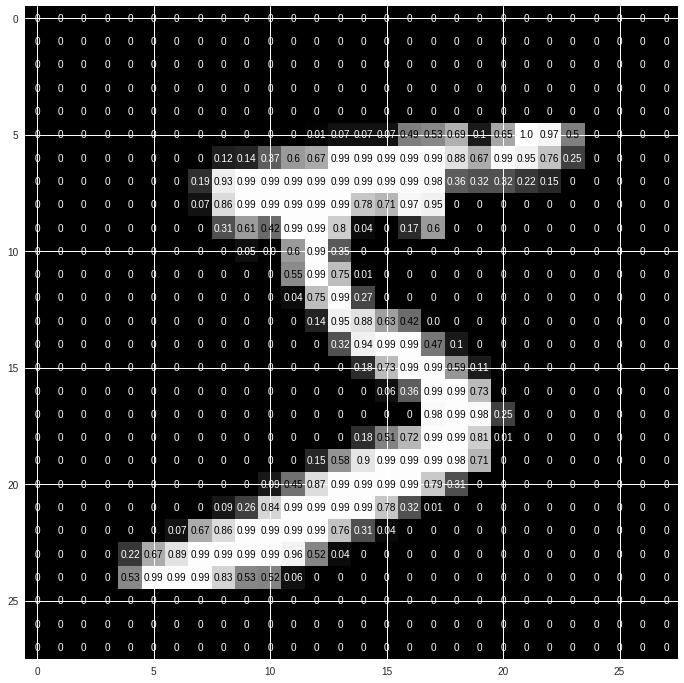

In [0]:
img = np.squeeze(images[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Sequential API

In [0]:
# [0-9] unique labels
num_classes = 10
epochs = 5

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        D_in = 784
        H = 16
        D_out = num_classes
        self.classifier = torch.nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.25),
            Flatten(),
            nn.Linear(12*12*64, 128),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        
        # 2 conv layer, with relu activation function
        x = self.classifier(x)
        return x

# initialize the NN
model = Net()
model = model.to(device)
print(model)

Net(
  (classifier): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25)
    (6): Flatten()
    (7): Linear(in_features=9216, out_features=128, bias=True)
    (8): Dropout(p=0.5)
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): LogSoftmax()
  )
)


In [0]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print (len(dataloaders[phase].dataset))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, epochs)

Epoch 0/4
----------
train Loss: 0.2784 Acc: 0.9138
60000
val Loss: 0.0693 Acc: 0.9517
10000
Epoch 1/4
----------
train Loss: 0.0877 Acc: 0.9710
60000
val Loss: 0.0472 Acc: 0.9609
10000
Epoch 2/4
----------
train Loss: 0.0665 Acc: 0.9777
60000
val Loss: 0.0423 Acc: 0.9624
10000
Epoch 3/4
----------
train Loss: 0.0560 Acc: 0.9801
60000
val Loss: 0.0396 Acc: 0.9634
10000
Epoch 4/4
----------
train Loss: 0.0485 Acc: 0.9818
60000
val Loss: 0.0356 Acc: 0.9634
10000
Training complete in 1m 9s
Best val Acc: 0.963379


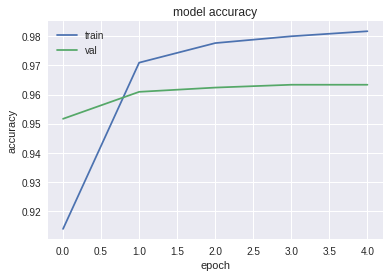

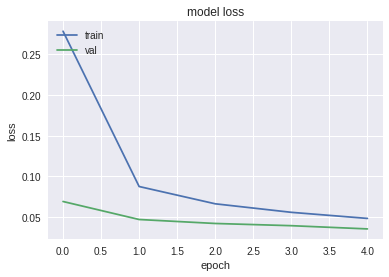

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    data = data.to(device)
    target = target.to(device)
    
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.034638

Test Accuracy of     0: 99% (782/785)
Test Accuracy of     1: 99% (881/883)
Test Accuracy of     2: 99% (827/835)
Test Accuracy of     3: 97% (800/824)
Test Accuracy of     4: 99% (787/793)
Test Accuracy of     5: 99% (722/727)
Test Accuracy of     6: 97% (724/740)
Test Accuracy of     7: 97% (802/820)
Test Accuracy of     8: 97% (768/785)
Test Accuracy of     9: 97% (789/808)

Test Accuracy (Overall): 98% (7882/8000)


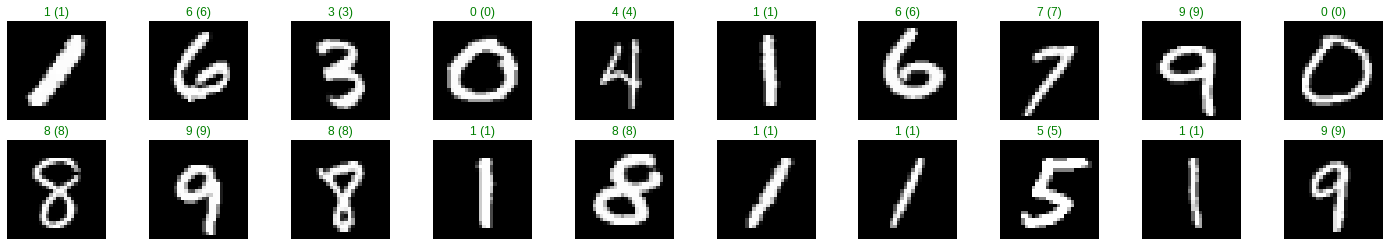

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)
labels = labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

Text(0.5,1,'100.00 % accuracy')

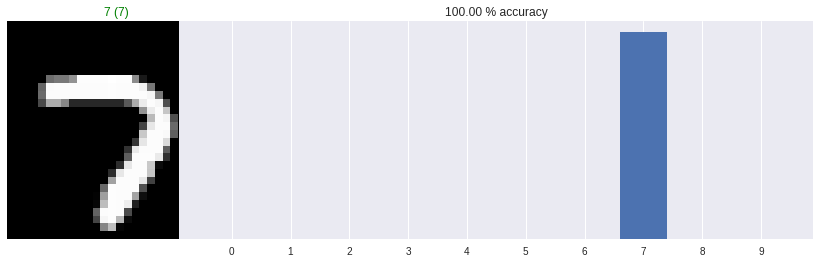

In [0]:
import random

random_idx = random.randint(0, len(test_loader.dataset))
# get sample outputs
image = test_loader.dataset[random_idx][0].to(device)

output = model(image[None, :])
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
label = test_loader.dataset[random_idx][1]
label = label.to(device)

# plot the images one example, along with predicted and true labels and probabilities
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(test_loader.dataset[random_idx][0].detach().squeeze(), cmap='gray')
ax.set_title("{} ({})".format(str(preds.cpu().numpy()[0]), str(label.cpu().numpy())),
             color=("green" if preds==label else "red"))
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
x_labels = torch.arange(10)
ax.bar(torch.arange(10), height=torch.exp(output).cpu().detach().squeeze(), tick_label=x_labels)
ax.set_title("{:.2f} % accuracy".format(float(torch.exp(output[:, preds])*100)))

## Functional API

In [0]:
# [0-9] unique labels
num_classes = 10
epochs = 5

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=0)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.output(x), dim=1)
        return x

# create a complete CNN
model = Net()
model = model.to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25)
  (dropout2): Dropout(p=0.5)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)


In [0]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print (len(dataloaders[phase].dataset))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [0]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, epochs)

Epoch 0/4
----------
train Loss: 0.3495 Acc: 0.8918
60000
val Loss: 0.0586 Acc: 0.9565
10000
Epoch 1/4
----------
train Loss: 0.1026 Acc: 0.9675
60000
val Loss: 0.0391 Acc: 0.9639
10000
Epoch 2/4
----------
train Loss: 0.0758 Acc: 0.9748
60000
val Loss: 0.0404 Acc: 0.9658
10000
Epoch 3/4
----------
train Loss: 0.0616 Acc: 0.9787
60000
val Loss: 0.0311 Acc: 0.9653
10000
Epoch 4/4
----------
train Loss: 0.0532 Acc: 0.9813
60000
val Loss: 0.0329 Acc: 0.9663
10000
Training complete in 1m 9s
Best val Acc: 0.966309


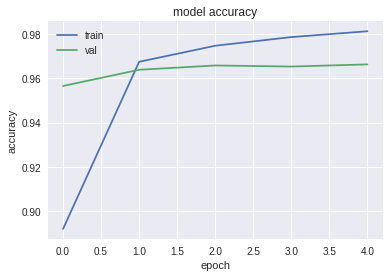

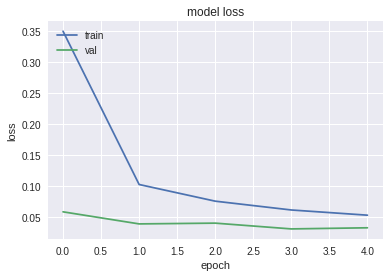

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
  
    data = data.to(device)
    target = target.to(device)  
  
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.026044

Test Accuracy of     0: 99% (782/785)
Test Accuracy of     1: 99% (881/883)
Test Accuracy of     2: 98% (825/835)
Test Accuracy of     3: 99% (820/824)
Test Accuracy of     4: 98% (784/793)
Test Accuracy of     5: 98% (714/727)
Test Accuracy of     6: 98% (732/740)
Test Accuracy of     7: 99% (812/820)
Test Accuracy of     8: 98% (774/785)
Test Accuracy of     9: 97% (787/808)

Test Accuracy (Overall): 98% (7911/8000)


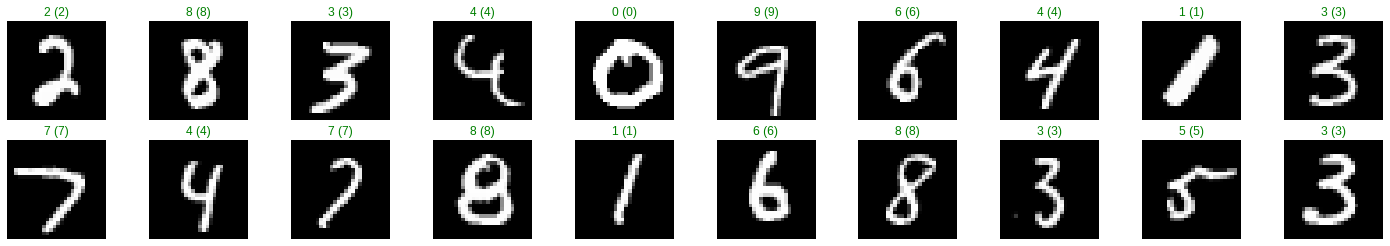

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)
labels = labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

Text(0.5,1,'100.00 % accuracy')

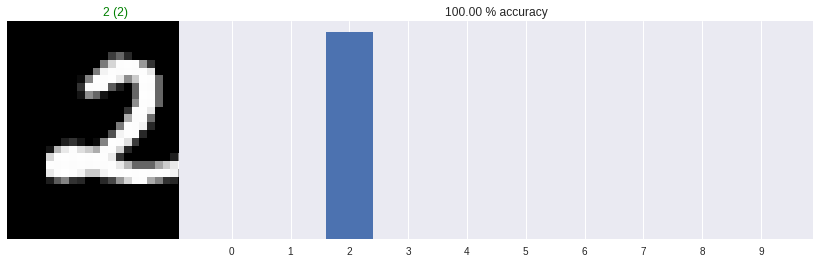

In [0]:
import random

random_idx = random.randint(0, len(test_loader.dataset))
# get sample outputs
image = test_loader.dataset[random_idx][0].to(device)

output = model(image[None, :])
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
label = test_loader.dataset[random_idx][1]
label = label.to(device)

# plot the images one example, along with predicted and true labels and probabilities
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(test_loader.dataset[random_idx][0].detach().squeeze(), cmap='gray')
ax.set_title("{} ({})".format(str(preds.cpu().numpy()[0]), str(label.cpu().numpy())),
             color=("green" if preds==label else "red"))
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
x_labels = torch.arange(10)
ax.bar(torch.arange(10), height=torch.exp(output).cpu().detach().squeeze(), tick_label=x_labels)
ax.set_title("{:.2f} % accuracy".format(float(torch.exp(output[:, preds])*100)))